# ゲーム理論（ナッシュ均衡）を用いたグリコゲームの最適戦略の研究
# Research of optimal strategy for Glico game using game theory (Nash equilibrium)

### グリコのゲーム説明
- プレイヤー２名で実施
- グーで勝ったら３点、チョキで勝ったら５点、パーで勝ったら６点を獲得
- 先に30点獲得したプレイヤーの勝利

### The rule of Glico Game
- two players participate in this game
- a player acquires 3 points by winning with a rock-hand, 5 points by winning with a scissors-hand, and 6 points by winning with a paper-hand
- a player who acquires 30 points earlier wins

In [1]:
# ライブラリの読み込み、設定
# import libraries and configure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from sympy import *

config = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'font.size': 14,
    'axes.linewidth': 1.0,
    'figure.dpi': 144
}
plt.rcParams.update(config)

plt.rcParams['figure.figsize'] = (25.0, 10.0)

In [2]:
stair_length = 10
hands_num = 3
rewards = [[(0, 0), (1, 0), (0, 2)],
         [(0, 1), (0, 0), (2, 0)],
         [(2, 0), (0, 2), (0, 0)]]

## rewardsの各要素の左右を入れ替えた上で、対称行列を返す関数
def reverse_rewards(rewards):
    rew_list = []
    for i in range(hands_num):
        rew = []
        for j in range(hands_num):
            rew.append((rewards[j][i][1], rewards[j][i][0]))
        rew_list.append(rew)
    return rew_list

## 連立方程式を立てる関数
#len(prob) = hands_num-1
#v(n,m), qg, qcの情報から
def make_eqs(rewards, prob, current_reward):
    eq_list = [] ## グー、チョキ、パーそれぞれに対する期待値を表す方程式３つを格納するリスト
    for i in range(hands_num): ## 各方程式を作る
        eq = 0
        for j in range(hands_num-1): ## １つの方程式に対して、まずグー、チョキの期待値を方程式に追加
            eq += rewards[i][j]*prob[j]
        eq += rewards[i][hands_num-1]*(1-sum(prob))-current_reward ##　最後にパーの期待値（変数の数を減らすため別扱い）と現在の期待利得を追加
        eq_list.append(eq)
    return eq_list

## make_eqsに引き渡すための関数
def make_rewards(v_list, n, m, v0=None):
    rew_list = []
    for i in range(hands_num):
        rew = []
        for j in range(hands_num):
            x, y = n-rewards[i][j][0], m-rewards[i][j][1]
            if x < 0 and y < 0: rew.append(0) ## x, yが両方とも0未満の場合は0を格納
            elif x < 0: rew.append(1) ## xが0未満になった場合は1を格納
            elif y < 0: rew.append(-1) ## yが0未満になった場合は-1を格納
            else: ## 階段の数よりも大きくなったら、初期値に戻す
                if x >= stair_length: x = stair_length-1
                if y >= stair_length: y = stair_length-1
                if v0 != None and x == n and y == m: rew.append(v0)
                else:rew.append(v_list[x][y])
        rew_list.append(rew)
    return rew_list

## optimize.rootに引き渡すための最終的な連立方程式を整理するための関数
def find_ans(li): ## liは引き渡されない、方程式を解くための引数
    v_list = [li[i*stair_length:(i+1)*stair_length] for i in range(stair_length)]
    li = li[stair_length**2:]
    qg_list = [li[i*stair_length:(i+1)*stair_length] for i in range(stair_length)]
    li = li[stair_length**2:]
    qc_list = [li[i*stair_length:(i+1)*stair_length] for i in range(stair_length)]
    eq_list = []
    for i in range(stair_length):
        for j in range(stair_length):
            eq_list.extend(make_eqs(make_rewards(v_list, i, j), [qg_list[j][i], qc_list[j][i]], v_list[i][j])) ## 末尾に結合
    return eq_list

## 初期値生成関数
def make_init():
    return [0]*(stair_length**2)+[0.33]*(stair_length**2*2)

# 求解（Problem Solving）
- Calculate optimal probability distribution of every hand based on Nash equilibrium
- stair_length = 階段の段数
- hands_num = 出せる手の数(グーチョキパーなら3)
- rewards = 大きさ(hands_num, hands_num)のリスト。双方が出した手ごとに、(自分が進む歩数, 相手が進む歩数)を指定する。

In [ ]:
stair_length = 30
hands_num = 3
rewards = [[(0, 0), (3, 0), (0, 6)],
         [(0, 3), (0, 0), (5, 0)],
         [(6, 0), (0, 5), (0, 0)]]

def optimizer(stair_length, hands_num, rewards):
    result = optimize.root(find_ans, make_init(), method="lm")
    print(result["success"])
    print(result["message"])
    x = result["x"]
    v_list = np.reshape(x[:stair_length**2], (stair_length, stair_length))
    qg_list = np.reshape(x[stair_length**2:stair_length**2*2], (stair_length, stair_length))
    qc_list = np.reshape(x[stair_length**2*2:], (stair_length, stair_length))
    return (v_list, qg_list, qc_list)

v_list, qg_list, qc_list = optimizer(stair_length, hands_num, rewards)

# 2人のプレイヤーが同じポイントを獲得している場合における最適な確率分布を表示
# Display the optimal probability distribution when both two players are scoring the same points.

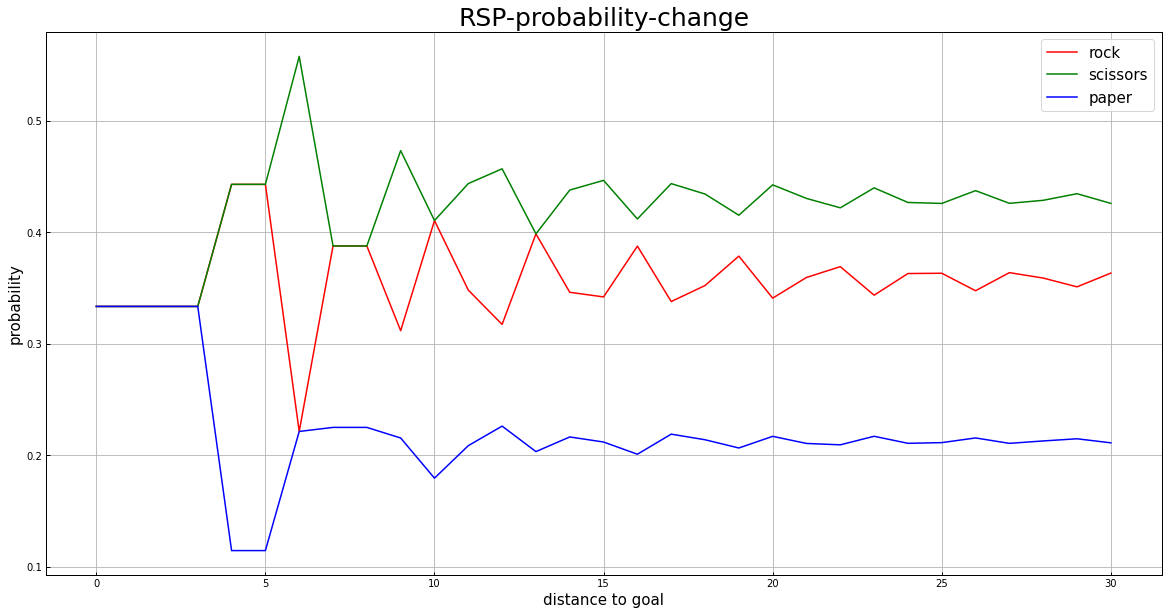

In [5]:
# 各地点における手の確率分布を表示(Display the probability distribution of hands at each points)
A, B, C = [1/3], [1/3], [1/3]
for i in range(0, stair_length):
    A.append(qg_list[i][i])
    B.append(qc_list[i][i])
    C.append(1-qg_list[i][i]-qc_list[i][i])
    
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.plot(A, label="rock", color="r")
plt.plot(B, label="scissors", color="g")
plt.plot(C, label="paper", color="b")
plt.title("GlicoGame-RSP-probability-shift", {"fontsize":25})
plt.xlabel("distance to goal", {"fontsize":15})
plt.ylabel("probability", {"fontsize":15})
plt.grid(True)
plt.legend(fontsize=15)
plt.show()

# 三次元プロット（3D plot）
- 各地点における最適な手の確率分布を色で表し、予想効用を縦軸に表示
- The probability distribution of hands at each point is represented by a color, and the expected utility is represented on the vertical axis.

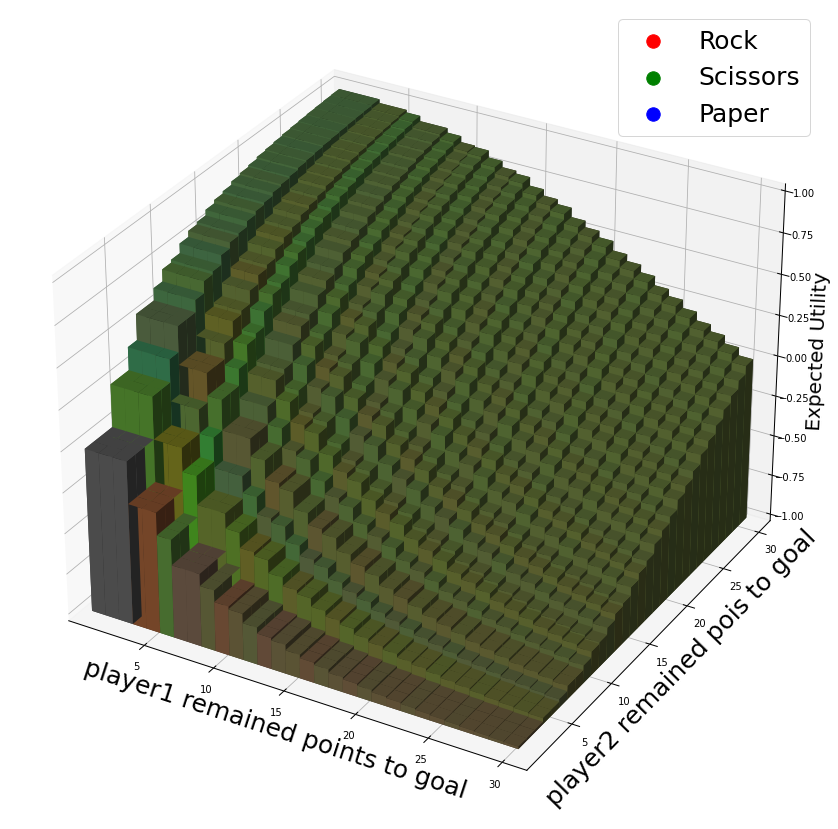

In [13]:
def myplot3d(v_list, qg_list = [], qc_list = []):
    x, y = np.meshgrid(np.arange(stair_length), np.arange(stair_length))
    x, y = x.ravel(), y.ravel()
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    if len(qg_list) == len(qc_list) == len(v_list):
        col_list = [(i, j, k) for i, j, k in zip(qg_list.T.ravel(), qc_list.T.ravel(), 1-qg_list.T.ravel()-qc_list.T.ravel())]
        
        ax.bar3d(x+0.5, y+0.5, np.zeros_like(x)-1, 1, 1, v_list.T.ravel()+1, color=col_list)
        ax.scatter([], [], color="r", label="Rock")
        ax.scatter([], [], color="g", label="Scissors")
        ax.scatter([], [], color="b", label="Paper")
        ax.legend(markerscale=3, fontsize="25")
    else:
        ax.bar3d(x+0.5, y+0.5, np.zeros_like(x)-1, 1, 1, v_list.T.ravel()+1)
    ax.set_zlim(-1, 1)
    ax.set_xlim(0.1, stair_length+1)
    ax.set_ylim(0.1, stair_length+1)
    ax.set_xlabel("player1 remained points to goal", {"fontsize":25})
    ax.set_ylabel("player2 remained pois to goal", {"fontsize":25})
    ax.set_zlabel("Expected Utility", {"fontsize":20})

#qg_list1, qc_list1 = qg_list, qc_list
myplot3d(v_list, qg_list, qc_list)